# Sequential AB Testing

## Imports

In [9]:
import scipy
import math
import random
import warnings
import numpy as np
import pandas as pd
import scipy.stats as scs
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# from ABTesting import DfHelper


In [10]:
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)


In [11]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from df_helper import DfHelper

## Data reading

In [12]:
helper = DfHelper()
missing_values = ["n/a", "na", "undefined"]
df = helper.read_csv("../data/AdSmartABdata.csv")
df.head(5)

2021-07-23 12:47:27,689 — DfHelper — DEBUG — file read as csv


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


## Transforming the data

In [13]:
def get_bernouli_series(engagment_list, success_list):
    bernouli_series = []

    for engagment, success in zip(engagment_list, success_list):
        no_list = (engagment - success) * [0]
        yes_list = (success) * [1]
        series_item = yes_list + no_list
        random.shuffle(series_item)
        bernouli_series += series_item
    return bernouli_series

In [14]:
def transform_data(df):
    clean_df = df.query("not (yes == 0 & no == 0)")
    
    # segment data into exposed and control groups
    exposed = clean_df[clean_df['experiment'] == 'exposed']
    control = clean_df[clean_df['experiment'] == 'control']

    # group data into hours.
    control['hour'] = control['hour'].astype('str')
    control['date_hour'] = pd.to_datetime(control['date'] + " " + control['hour'] + ":00" + ":00")
    control['date_hour'] = control['date_hour'].map(lambda x:  pd.Timestamp(x, tz=None).strftime('%Y-%m-%d:%H'))

    exposed['hour'] = exposed['hour'].astype('str')
    exposed['date_hour'] = pd.to_datetime( exposed['date'] + " " + exposed['hour'] + ":00" + ":00")
    exposed['date_hour'] = exposed['date_hour'].map( lambda x:  pd.Timestamp(x, tz=None).strftime('%Y-%m-%d:%H'))

    # create two dataframes with bernouli series 1 for posetive(yes) and 0 for negative(no)
    cont = exposed.groupby('date_hour').agg({'yes': 'sum', 'no': 'count'})
    cont = cont.rename(columns={'no': 'engagement', 'yes': 'success'})
    control_bernouli = get_bernouli_series(
        cont['engagement'].to_list(), cont['success'].to_list())

    exp = exposed.groupby('date_hour').agg({'yes': 'sum', 'no': 'count'})
    exp = exp.rename(columns={'no': 'engagement', 'yes': 'success'})
    exposed_bernouli = get_bernouli_series(
        exp['engagement'].to_list(), exp['success'].to_list())

    return np.array(control_bernouli), np.array(exposed_bernouli)


In [15]:
control, exposed = transform_data(df)
control

array([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,

## SPRT

In [16]:
def conditionalSPRT(x, y, t1, alpha=0.05, beta=0.10, stop=None):

    if t1 <= 1:
        print('warning', "Odd ratio should exceed 1.")
    if (alpha > 0.5) | (beta > 0.5):
        print('warning', "Unrealistic values of alpha or beta were passed."
              + " You should have good reason to use large alpha & beta values")
    if stop != None:
        stop = math.floor(n0)

    def comb(n, k):
        return math.factorial(n) // math.factorial(k) // math.factorial(n - k)

    def lchoose(b, j):
        a = []
        if (type(j) is list) | (isinstance(j, np.ndarray) == True):
            if len(j) < 2:
                j = j[0]
        if (type(j) is list) | (isinstance(j, np.ndarray) == True):
            for k in j:
                n = b
                if (0 <= k) & (k <= n):
                    a.append(math.log(comb(n, k)))
                else:
                    a.append(0)
        else:
            n = b
            k = j
            if (0 <= k) & (k <= n):
                a.append(math.log(comb(n, k)))
            else:
                a.append(0)

        return np.array(a)

    def g(x, r, n, t1, t0=1):
        return -math.log(h(x, r, n, t1))+math.log(h(x, r, n, t0))

    def h(x, r, n, t=1):

        return f(r, n, t, offset=ftermlog(x, r, n, t))

    def f(r, n, t, offset=0):
        upper = max(0, r-n)
        lower = min(n, r)
        rng = list(range(upper, lower+1))
        return np.sum(fterm(rng, r, n, t, offset))

    def fterm(j, r, n, t, offset=0):
        ftlog = ftermlog(j, r, n, t, offset)
        return np.array([math.exp(ex) for ex in ftlog])

    def ftermlog(j, r, n, t, offset=0):

        xx = r-j
        lch = lchoose(n, j)
        lchdiff = lchoose(n, xx)
        lg = np.array(j)*math.log(t)
        lgsum = lch+lchdiff
        lgsum2 = lgsum+lg
        lgdiff = lgsum2-offset

        return lgdiff

    def logf(r, n, t, offset=0):

        z = f(r, n, t, offset)
        if z > 0:
            return math.log(z)
        else:
            return np.nan

    def clowerUpper(r, n, t1c, t0=1, alpha=0.05, beta=0.10):

        offset = ftermlog(math.ceil(r/2), r, n, t1c)
        z = logf(r, n, t1c, logf(r, n, t0, offset)+offset)
        a = -math.log(alpha/(1-beta))
        b = math.log(beta/(1-alpha))
        lower = b
        upper = 1+a
        return (np.array([lower, upper])+z)/math.log(t1c/t0)

    l = math.log(beta/(1-alpha))
    u = -math.log(alpha/(1-beta))
    sample_size = min(len(x), len(y))
    n = np.array(range(1, sample_size+1))

    if stop != None:
        n = np.array([z for z in n if z <= stop])
    x1 = np.cumsum(x[n-1])
    r = x1+np.cumsum(y[n-1])
    # recurcively calls g
    stats = np.array(list(map(g, x1, r, n, [t1]*len(x1))))
    #
    # Perform the test by finding the first index, if any, at which `stats`
    # falls outside the open interval (l, u).
    #
    clu = list(map(clowerUpper, r, n, [
               t1]*len(r), [1]*len(r), [alpha]*len(r), [beta]*len(r)))
    limits = []
    for v in clu:
        inArray = []
        for vin in v:
            inArray.append(math.floor(vin))
        limits.append(np.array(inArray))
    limits = np.array(limits)

    k = np.where((stats >= u) | (stats <= l))
    cvalues = stats[k]
    if cvalues.shape[0] < 1:
        k = np.nan
        outcome = 'Unable to conclude.Needs more sample.'
    else:
        k = np.min(k)
        if stats[k] >= u:
            outcome = f'Exposed group produced a statistically significant increase.'
        else:
            outcome = 'Their is no statistically significant difference between two test groups'
    if (stop != None) & (k == np.nan):
      #
      # Truncate at trial stop, using Meeker's H0-conservative formula (2.2).
      # Leave k=NA to indicate the decision was made due to truncation.
      #
        c1 = clowerUpper(r, stop, t1, alpha, beta)
        c1 = math.floor(np.mean(c1)-0.5)
        if x1[n0] <= c1:
            truncate_decision = 'h0'
            outcome = 'Maximum Limit Decision. The aproximate decision point shows their is no statistically significant difference between two test groups'
        else:
            truncate_decision = 'h1'
            outcome = f'Maximum Limit Decision. The aproximate decision point shows exposed group produced a statistically significant increase.'
        truncated = stop
    else:
        truncate_decision = 'Non'
        truncated = np.nan
    return (outcome, n, k, l, u, truncated, truncate_decision, x1, r, stats, limits)


## ConditionalSPRT

In [18]:
class ConditionalSPRT:
     
    def __init__(self, x, y, odd_ratio, alpha=0.05, beta=0.10, stop=None):
        self.x = x
        self.y = y
        self.odd_ratio = odd_ratio
        self.alpha = alpha
        self.beta = beta
        self.stop = stop
   
    def run_test(self):
        res = conditionalSPRT( self.x, 
                               self.y, 
                               self.odd_ratio,
                               self.alpha, 
                               self.beta,
                               self.stop)
        return res

    def getResult(self, res, nobs):
        outcome, n, k, l, u, truncated, truncate_decision, x1, r, stats, limits = res

        lower = limits[:, 0]
        upper = limits[:, 1]
        output_dict = {'values': x1, 'lower': lower, 'upper': upper}
        output_df = pd.DataFrame(output_dict, columns=[
            'values', 'lower', 'upper'], index=x1)
        output_df.index.name = "n"
        print("Decision:\t" + outcome + "\n")
        print(output_df.round(3).iloc[-nobs:])

    def plot(self, res):
        fig, ax = plt.subplots(figsize=(16, 12))
        outcome, n, k, l, u, truncated, truncate_decision, x1, r, stats, limits = self.res
        yl = limits[:, 0]
        yu = limits[:, 1]

        ax.scatter(n, x1, color="#000000", zorder=1000, clip_on=False)
        lower_line, = ax.plot(n, yl, color="#00aedb", linewidth=1)
        upper_line, = ax.plot(n, yu, color="#d41243", linewidth=1)
        yticks, yticklabels = plt.yticks()
        ymin = yticks[0]
        ymax = yticks[-1]

        ax.fill_between(n, yl, ymin, color="#00aedb", alpha=0.5)
        ax.fill_between(n, yu, ymax, color="#d41243", alpha=0.5)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        plt.xlabel("Observations")
        plt.ylabel("Cumulative Sum")
        plt.legend(handles=[upper_line, lower_line], labels=[
                   "Reject Null", "Accept Null"], fontsize=10, loc=2)
        plt.show()

In [19]:
alpha = 0.5
beta = 0.10
odd_ratio = 1.01

conditionalSPRTObj = ConditionalSPRT(exposed, control, odd_ratio, alpha, beta)
res = conditionalSPRTObj.run_test()

In [20]:
conditionalSPRTObj.getResult(res, 10)

TypeError: getResult() missing 1 required positional argument: 'nobs'

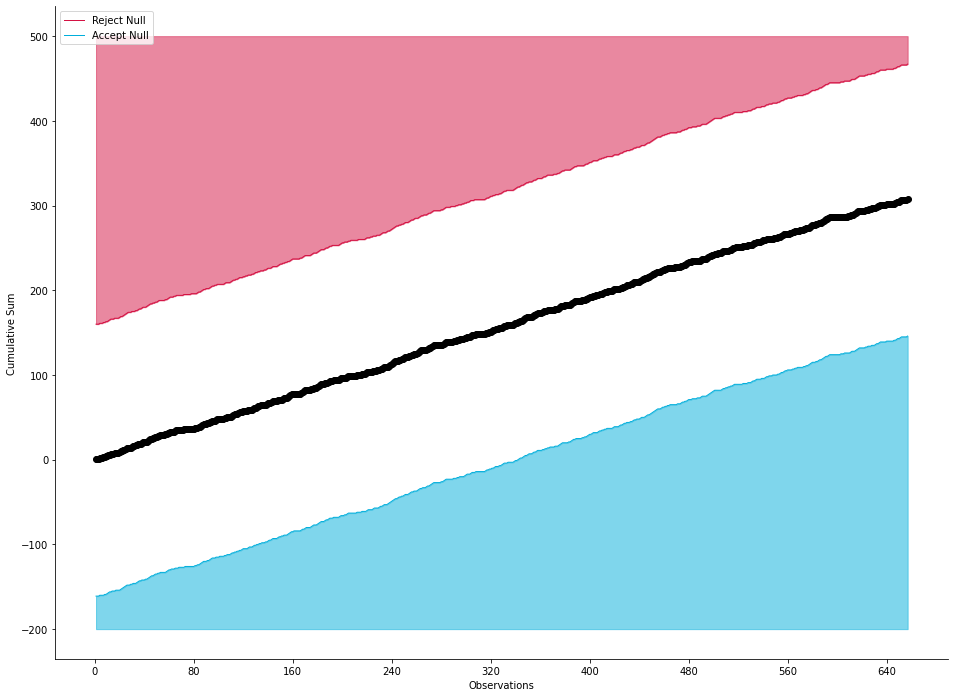

In [ ]:
plotBoundary(res)